<a href="https://colab.research.google.com/github/Suraba03/ml_san_francisco_permits/blob/main/san_fancisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data and first glance

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!ls

drive  sample_data


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv')

<ipython-input-3-5a9255161ba3>:1: DtypeWarning: Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv')


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,NaN,"ground fl facade: to erect illuminated, electr...",expired,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,NaN,6.0,NaN,NaN,NaN,11/03/2016,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,issued,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,NaN,installation of separating wall,withdrawn,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,20000.0,NaN,retail sales,39.0,retail sales,39.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,complete,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,issued,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [6]:
df.shape

(198900, 43)

# preprocessing

let's remove white spaces from columns names

In [7]:
df = df.rename(lambda name: name.replace(" ", ""), axis='columns')

let's divide features list into two groups: numerical and categorical

In [8]:
num_cols = [col for col in df.columns if "int" in str(df[col].dtype) or "float" in str(df[col].dtype)]
cat_cols = [col for col in df.columns if "object" == str(df[col].dtype) and col != "CurrentStatus"]
print(num_cols)
print(cat_cols)

['PermitType', 'StreetNumber', 'Unit', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ExistingConstructionType', 'ProposedConstructionType', 'SupervisorDistrict', 'Zipcode', 'RecordID']
['PermitNumber', 'PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetNumberSuffix', 'StreetName', 'StreetSuffix', 'UnitSuffix', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'CompletedDate', 'FirstConstructionDocumentDate', 'StructuralNotification', 'VoluntarySoft-StoryRetrofit', 'FireOnlyPermit', 'PermitExpirationDate', 'ExistingUse', 'ProposedUse', 'TIDFCompliance', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SitePermit', 'Neighborhoods-AnalysisBoundaries', 'Location']


In [9]:
target = "CurrentStatus"

these CurrentStatus values are useless because they are still in process, so that let's **drop them**

In [10]:
df = df[(df['CurrentStatus'] != 'filed') &
       (df['CurrentStatus'] != 'withdrawn') &
       (df['CurrentStatus'] != 'expired') &
       (df['CurrentStatus'] != 'plancheck') &
       (df['CurrentStatus'] != 'disapproved') &
       (df['CurrentStatus'] != 'appeal') ]

In [11]:
df.shape

(183713, 43)

Well we've lost apprx 15k rows, not so bad

Now let's divide values in **CurrentStatus** into two groups:
+ positive (value 1): application was rejected))
+ negative (value 0): application was approved

So lets consider ```[cancelled, suspend, revoked]``` as a **rejected** applications and ```[complete, issued, approved, reinstated, incomplete]``` as **approved** ones.

In [12]:
df['CurrentStatus'] = df['CurrentStatus'].map({'cancelled': 1, 'suspend': 1, 'revoked': 1,
                                                 'complete': 0, 'issued': 0, 'approved': 0, 
                                                 'reinstated': 0, 'incomplete': 0});

In [13]:
df['CurrentStatus'] = df['CurrentStatus'].astype('int64');

In [14]:
import seaborn as sns

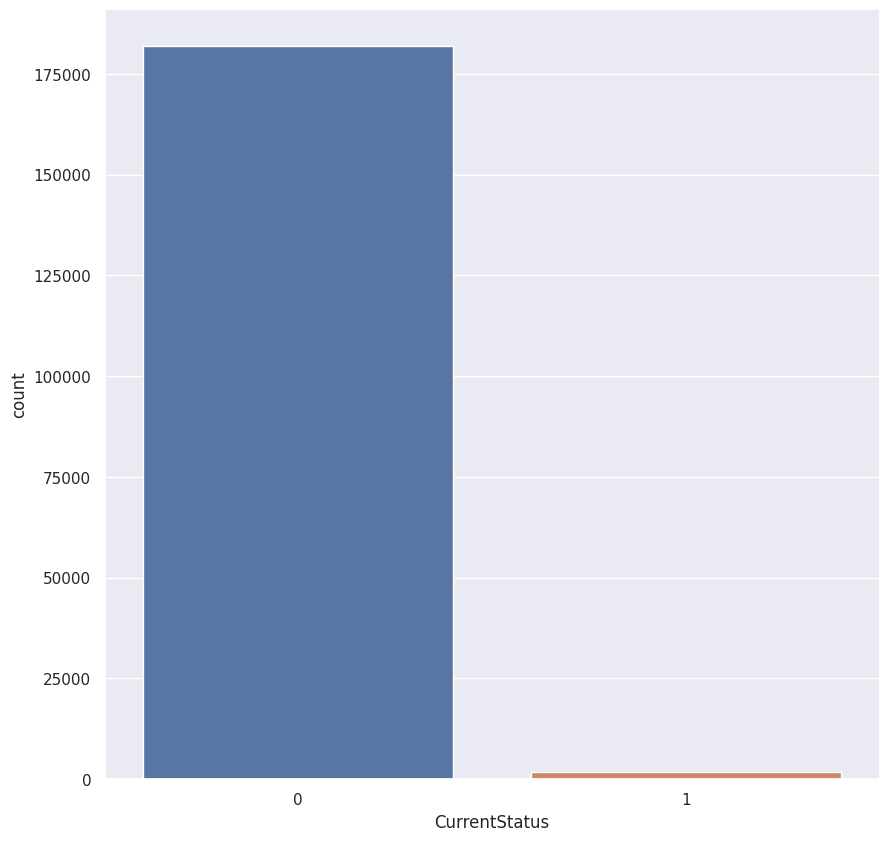

In [15]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df);

In [16]:
df[target].value_counts() / df.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

just a sanity check

In [17]:
set(num_cols+cat_cols + [target]) == set(df.columns)

True

# deal with missing values

In [ ]:
for i in df.columns:
    print(i)

PermitNumber
PermitType
PermitTypeDefinition
PermitCreationDate
Block
Lot
StreetNumber
StreetNumberSuffix
StreetName
StreetSuffix
Unit
UnitSuffix
Description
CurrentStatus
CurrentStatusDate
FiledDate
IssuedDate
CompletedDate
FirstConstructionDocumentDate
StructuralNotification
NumberofExistingStories
NumberofProposedStories
VoluntarySoft-StoryRetrofit
FireOnlyPermit
PermitExpirationDate
EstimatedCost
RevisedCost
ExistingUse
ExistingUnits
ProposedUse
ProposedUnits
Plansets
TIDFCompliance
ExistingConstructionType
ExistingConstructionTypeDescription
ProposedConstructionType
ProposedConstructionTypeDescription
SitePermit
SupervisorDistrict
Neighborhoods-AnalysisBoundaries
Zipcode
Location
RecordID


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         183713 non-null  object 
 1   PermitType                           183713 non-null  int64  
 2   PermitTypeDefinition                 183713 non-null  object 
 3   PermitCreationDate                   183713 non-null  object 
 4   Block                                183713 non-null  object 
 5   Lot                                  183713 non-null  object 
 6   StreetNumber                         183713 non-null  int64  
 7   StreetNumberSuffix                   1992 non-null    object 
 8   StreetName                           183713 non-null  object 
 9   StreetSuffix                         181131 non-null  object 
 10  Unit                                 27280 non-null   float64
 11  UnitSuffix   

In [ ]:
df['EstimatedCost'].count()

146648

In [18]:
list_to_drop = []
for col in num_cols + cat_cols + [target]:
    if df[col].count() < 130000:
        list_to_drop.append(col)
df2 = df.drop(list_to_drop, axis=1)

In [ ]:
df2[df2['CurrentStatus'] == 1].shape

(1779, 34)

In [ ]:
df2[df2['CurrentStatus'] == 0].count()

PermitNumber                           181934
PermitType                             181934
PermitTypeDefinition                   181934
PermitCreationDate                     181934
Block                                  181934
Lot                                    181934
StreetNumber                           181934
StreetName                             181934
StreetSuffix                           179360
Description                            181849
CurrentStatus                          181934
CurrentStatusDate                      181934
FiledDate                              181934
IssuedDate                             181153
FirstConstructionDocumentDate          181131
NumberofExistingStories                141161
NumberofProposedStories                141118
PermitExpirationDate                   144216
EstimatedCost                          144884
RevisedCost                            181880
ExistingUse                            142717
ExistingUnits                     

In [ ]:
df2[df2[target] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1779 entries, 90 to 197604
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PermitNumber                         1779 non-null   object 
 1   PermitType                           1779 non-null   int64  
 2   PermitTypeDefinition                 1779 non-null   object 
 3   PermitCreationDate                   1779 non-null   object 
 4   Block                                1779 non-null   object 
 5   Lot                                  1779 non-null   object 
 6   StreetNumber                         1779 non-null   int64  
 7   StreetName                           1779 non-null   object 
 8   StreetSuffix                         1771 non-null   object 
 9   Description                          1775 non-null   object 
 10  CurrentStatus                        1779 non-null   int64  
 11  CurrentStatusDate          

In [ ]:
df2[df3[target] == 0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181934 entries, 1 to 198899
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         181934 non-null  object 
 1   PermitType                           181934 non-null  int64  
 2   PermitTypeDefinition                 181934 non-null  object 
 3   PermitCreationDate                   181934 non-null  object 
 4   Block                                181934 non-null  object 
 5   Lot                                  181934 non-null  object 
 6   StreetNumber                         181934 non-null  int64  
 7   StreetName                           181934 non-null  object 
 8   StreetSuffix                         179360 non-null  object 
 9   Description                          181849 non-null  object 
 10  CurrentStatus                        181934 non-null  int64  
 11  CurrentStatus

In [19]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 34 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitNumber                         183713 non-null  object 
 1   PermitType                           183713 non-null  int64  
 2   PermitTypeDefinition                 183713 non-null  object 
 3   PermitCreationDate                   183713 non-null  object 
 4   Block                                183713 non-null  object 
 5   Lot                                  183713 non-null  object 
 6   StreetNumber                         183713 non-null  int64  
 7   StreetName                           183713 non-null  object 
 8   StreetSuffix                         181131 non-null  object 
 9   Description                          183624 non-null  object 
 10  CurrentStatus                        183713 non-null  int64  
 11  CurrentStatus

In [181]:
df3 = df2.drop(['PermitNumber', 'PermitType', 'StreetSuffix', 'PermitExpirationDate', 'ExistingConstructionType', 'ProposedConstructionType', 'Zipcode', 'Location', 'RecordID'], axis=1)

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 183713 non-null  object 
 1   PermitCreationDate                   183713 non-null  object 
 2   Block                                183713 non-null  object 
 3   Lot                                  183713 non-null  object 
 4   StreetNumber                         183713 non-null  int64  
 5   StreetName                           183713 non-null  object 
 6   Description                          183624 non-null  object 
 7   CurrentStatus                        183713 non-null  int64  
 8   CurrentStatusDate                    183713 non-null  object 
 9   FiledDate                            183713 non-null  object 
 10  IssuedDate                           182589 non-null  object 
 11  FirstConstruc

In [150]:
num_cols3 = [col for col in df3.columns if "int" in str(df3[col].dtype) or "float" in str(df3[col].dtype)]
cat_cols3 = [col for col in df3.columns if "object" == str(df3[col].dtype) and col != "CurrentStatus"]
print(num_cols3)
print(cat_cols3)

['StreetNumber', 'CurrentStatus', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'SupervisorDistrict']
['PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetName', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'FirstConstructionDocumentDate', 'ExistingUse', 'ProposedUse', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'Neighborhoods-AnalysisBoundaries']


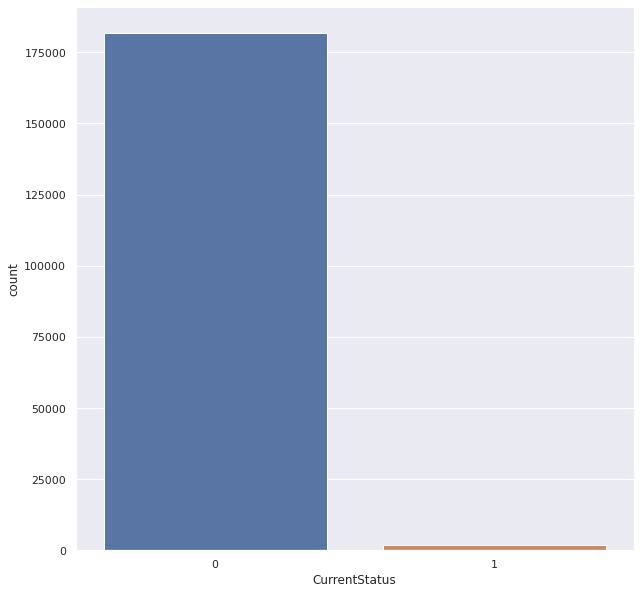

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df3);

In [226]:
df2.PermitTypeDefinition.value_counts()

otc alterations permit                 169284
additions alterations or repairs        10241
sign - erect                             2474
new construction wood frame               631
demolitions                               422
wall or painted sign                      383
new construction                          194
grade or quarry or fill or excavate        84
Name: PermitTypeDefinition, dtype: int64

In [ ]:
df3[target].value_counts() / df3.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183713 entries, 1 to 198899
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 183713 non-null  object 
 1   PermitCreationDate                   183713 non-null  object 
 2   Block                                183713 non-null  object 
 3   Lot                                  183713 non-null  object 
 4   StreetNumber                         183713 non-null  int64  
 5   StreetName                           183713 non-null  object 
 6   Description                          183624 non-null  object 
 7   CurrentStatus                        183713 non-null  int64  
 8   CurrentStatusDate                    183713 non-null  object 
 9   FiledDate                            183713 non-null  object 
 10  IssuedDate                           182589 non-null  object 
 11  FirstConstruc

In [ ]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
1,sign - erect,04/19/2016,0306,007,440,Geary,remove (e) awning and associated signs.,0,08/03/2017,04/19/2016,08/03/2017,08/03/2017,7.0,NaN,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,constr type 3,NaN,3.0,Tenderloin
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/18/2017,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
4,demolitions,11/28/2016,0342,001,950,Market,demolish retail/office/commercial 3-story buil...,0,12/01/2017,11/28/2016,12/01/2017,11/20/2017,3.0,NaN,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,constr type 3,NaN,6.0,Tenderloin
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,07/06/2017,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,06/30/2017,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset


In [151]:
df3['StreetNumber_int'] = df3.StreetNumber.astype('int64')

<Axes: xlabel='StreetNumber_int', ylabel='CurrentStatus'>

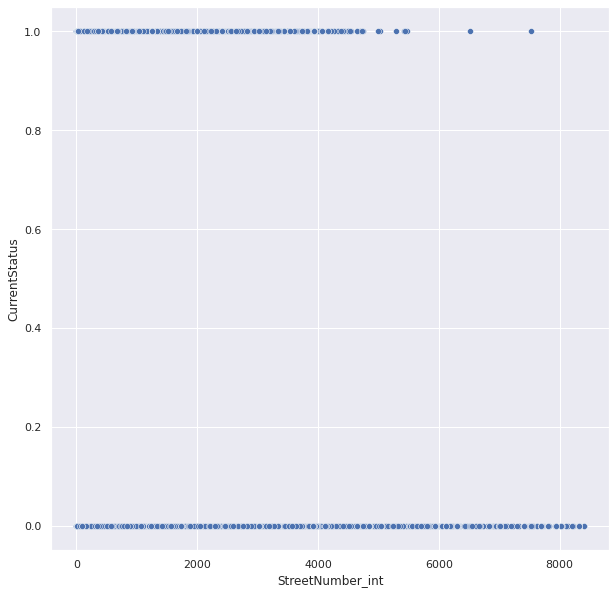

In [ ]:
sns.scatterplot(data=df3, x="StreetNumber_int", y=target)

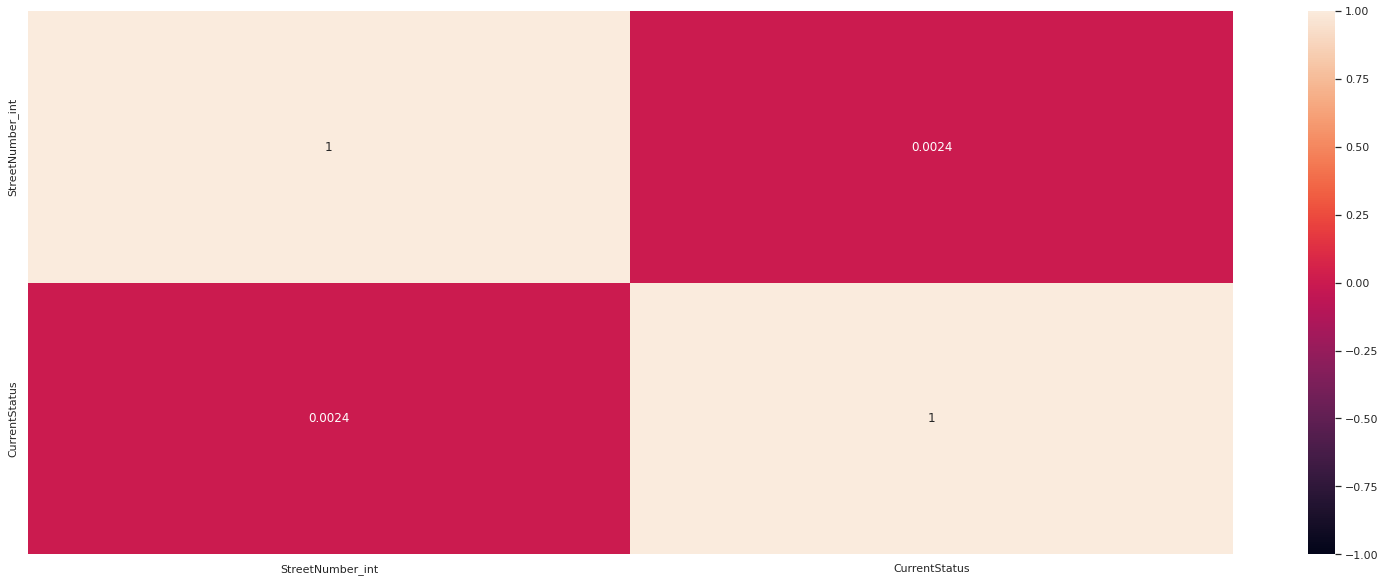

In [ ]:
sns.set(rc={'figure.figsize':(27,10)})

corr_matrix = df3[["StreetNumber_int"] + [target]].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [ ]:
columns_to_show1 = ['Block', 'Lot', 'StreetNumber', 'StreetName']
columns_to_show = ['StreetName']

df3.groupby([target])[columns_to_show].describe()

StreetName                      
                   count unique      top  freq
CurrentStatus                                 
0                 181934   1689   Market  5047
1                   1779    503  Mission    45

In [ ]:
df3.StreetName.unique()

array(['Geary', 'Pacific', 'Market', ..., 'Chain Of Lakes', 'Unknown',
       'Ignacio'], dtype=object)

In [ ]:
lst = []
for name in df3.StreetName.unique():
    cnts = list(df3[df3.StreetName == name][target].value_counts())
    #print(cnts)
    if len(cnts) == 1:
        if df3[df3.StreetName == name][target].unique()[0] == 0:
            lst.append((name, 0, cnts[0], 0))
        else:
            lst.append((name, 9999999, 0, cnts[0]))
    elif len(cnts) == 0: 
        lst.append((name, -1, 0, 0))
    else:    
        lst.append((name, cnts[1]/cnts[0], cnts[0], cnts[1]))

In [ ]:
lst.sort(key=(lambda x: x[1]), reverse=True)
lst

In [ ]:
lst[-50:-1]

In [ ]:
df3[df3[target] == 0].info()

In [ ]:
df3[df3[target] == 1].info()

In [ ]:
df3.drop_duplicates()

In [ ]:
df_without_nan_cols = df3.drop(['FirstConstructionDocumentDate'], axis=1)

In [ ]:
df_without_nan_cols.dropna(inplace=True)

In [ ]:
df_without_nan_cols.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,StreetNumber_int
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill,1230
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill,800
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset,1291
24,otc alterations permit,08/08/2017,0542,039,1,Charlton,re-roofing,0,08/08/2017,08/08/2017,08/08/2017,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina,1
25,otc alterations permit,08/16/2017,1824,006,1435,29th,re-roofing,0,08/16/2017,08/16/2017,08/16/2017,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside,1435


# Baseline

In [182]:
df3 = df3.dropna(axis=0)

In [183]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,11/07/2016,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/18/2017,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,06/14/2017,4105,009,800,Indiana,evac maps,0,07/06/2017,06/14/2017,07/06/2017,07/06/2017,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,06/30/2017,1739,020,1291,11th,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,06/30/2017,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,08/08/2017,0542,039,1,Charlton,re-roofing,0,08/08/2017,08/08/2017,08/08/2017,08/08/2017,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,08/16/2017,1824,006,1435,29th,re-roofing,0,08/16/2017,08/16/2017,08/16/2017,08/16/2017,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside


<Axes: xlabel='CurrentStatus', ylabel='count'>

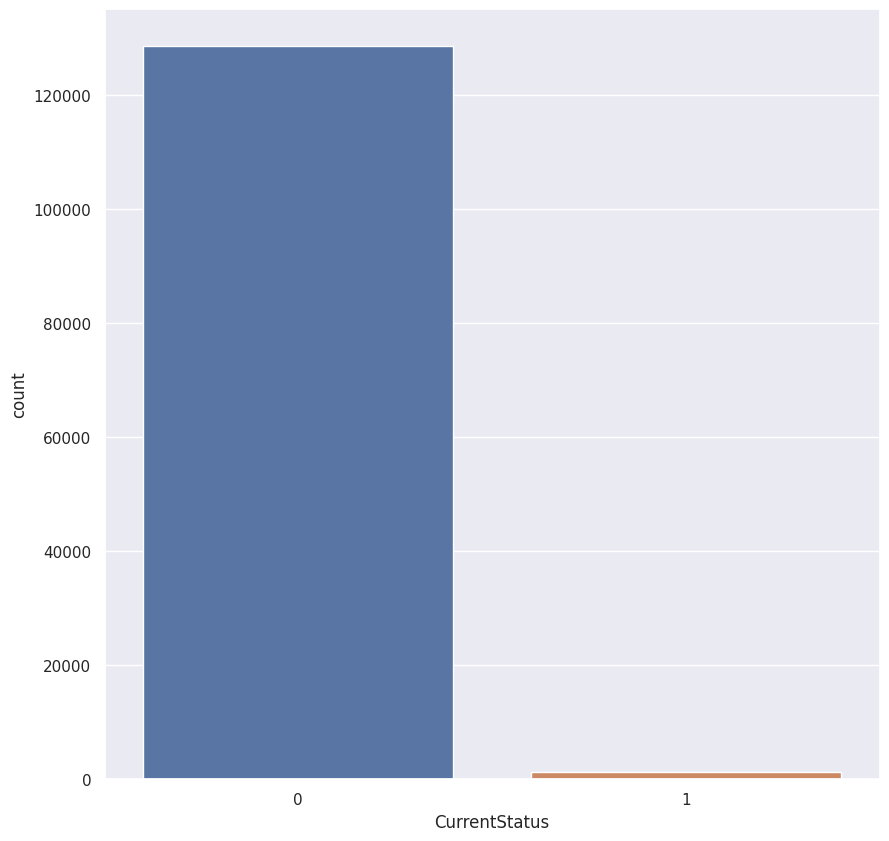

In [184]:
sns.countplot(data=df3, x=target)

In [185]:
df3[target].value_counts()[0] / df3[target].value_counts()[1]

97.65679574791191

In [186]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 129931 non-null  object 
 1   PermitCreationDate                   129931 non-null  object 
 2   Block                                129931 non-null  object 
 3   Lot                                  129931 non-null  object 
 4   StreetNumber                         129931 non-null  int64  
 5   StreetName                           129931 non-null  object 
 6   Description                          129931 non-null  object 
 7   CurrentStatus                        129931 non-null  int64  
 8   CurrentStatusDate                    129931 non-null  object 
 9   FiledDate                            129931 non-null  object 
 10  IssuedDate                           129931 non-null  object 
 11  FirstConstruc

In [187]:
for c in [col for col in df3.columns if "Date" in col]:
    df3[c] = pd.to_datetime(df3[c], format='%m/%d/%Y')

In [188]:
df3.shape

(129931, 25)

In [189]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   PermitTypeDefinition                 129931 non-null  object        
 1   PermitCreationDate                   129931 non-null  datetime64[ns]
 2   Block                                129931 non-null  object        
 3   Lot                                  129931 non-null  object        
 4   StreetNumber                         129931 non-null  int64         
 5   StreetName                           129931 non-null  object        
 6   Description                          129931 non-null  object        
 7   CurrentStatus                        129931 non-null  int64         
 8   CurrentStatusDate                    129931 non-null  datetime64[ns]
 9   FiledDate                            129931 non-null  datetime64[ns]
 

In [190]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,2016-11-07,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,2017-07-24,2016-11-07,2017-07-18,2017-07-18,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,2017-06-14,4105,009,800,Indiana,evac maps,0,2017-07-06,2017-06-14,2017-07-06,2017-07-06,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,2017-06-30,1739,020,1291,11th,re-roofing,0,2017-07-12,2017-06-30,2017-06-30,2017-06-30,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,2017-08-08,0542,039,1,Charlton,re-roofing,0,2017-08-08,2017-08-08,2017-08-08,2017-08-08,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,2017-08-16,1824,006,1435,29th,re-roofing,0,2017-08-16,2017-08-16,2017-08-16,2017-08-16,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside


In [191]:
for c in [col for col in df3.columns if "Date" in col]:
    df3[c] = df3[c].values.astype(np.int64)

In [192]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 129931 non-null  object 
 1   PermitCreationDate                   129931 non-null  int64  
 2   Block                                129931 non-null  object 
 3   Lot                                  129931 non-null  object 
 4   StreetNumber                         129931 non-null  int64  
 5   StreetName                           129931 non-null  object 
 6   Description                          129931 non-null  object 
 7   CurrentStatus                        129931 non-null  int64  
 8   CurrentStatusDate                    129931 non-null  int64  
 9   FiledDate                            129931 non-null  int64  
 10  IssuedDate                           129931 non-null  int64  
 11  FirstConstruc

In [193]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside


to drop: block, lot, streetname, description

In [194]:
df3.StreetNumber = df3.StreetNumber.astype(np.int64)

<Axes: >

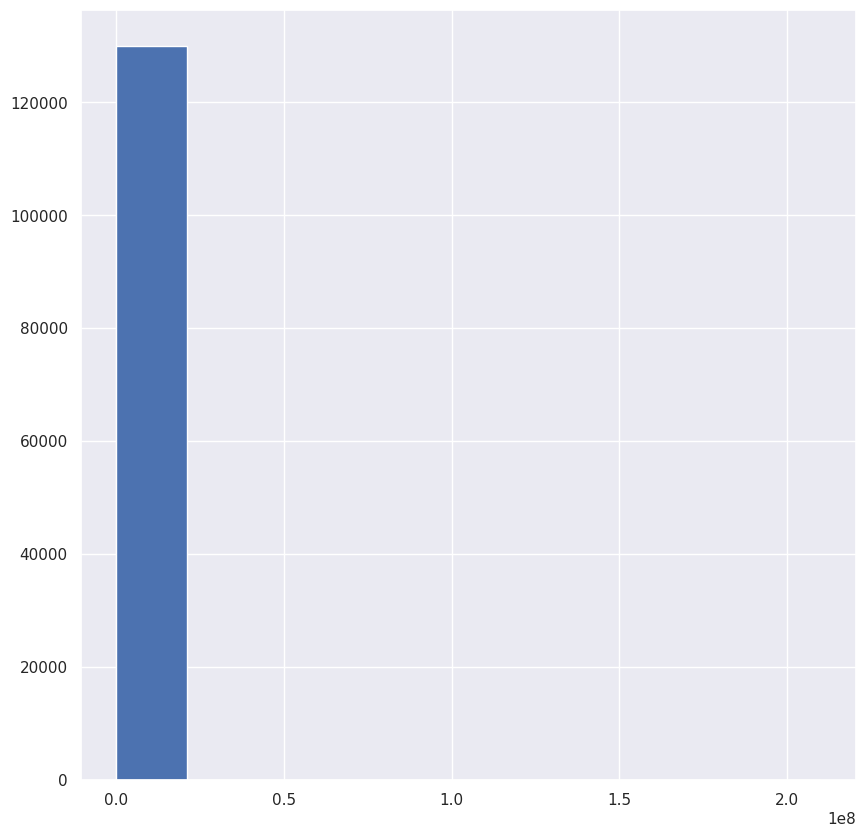

In [195]:
df3.RevisedCost.hist()

In [196]:
dct1 = df3.ExistingUse.value_counts().to_dict()
dct2 = df3.ProposedUse.value_counts().to_dict()

In [197]:
#df3['ExistingUse'] = df3['ExistingUse'].map(dct1)
#df3['ProposedUse'] = df3['ProposedUse'].map(dct2)

In [198]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,apartments,9.0,apartments,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside


In [199]:
s = df3.ExistingUse.value_counts()
s1 = df3.ProposedUse.value_counts()
l_q = list()
for elem in np.arange(0.1, 1, 0.1):
    l_q.append(s.quantile(elem))

l_q1 = list()
for elem in np.arange(0.1, 1, 0.1):
    l_q1.append(s.quantile(elem))

In [200]:
l_q

[2.0,
 4.0,
 7.0,
 15.0,
 24.0,
 45.0,
 71.39999999999999,
 125.19999999999997,
 439.10000000000025]

In [201]:
def f1(row, l_q):
    acc = 0
    for a in range(len(l_q)):
        if row > l_q[a]:
            acc += 1
    return acc

In [202]:
#df3.ExistingUse = df3.ExistingUse.map(lambda x: f1(x, l_q))
#df3.ProposedUse = df3.ProposedUse.map(lambda x: f1(x, l_q1))

In [203]:
df3.head(2)

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill


In [204]:
#df3.drop(['Block', 'Lot', 'StreetName', 'Description', 'StreetNumber_int'], axis=1, inplace=True)

In [214]:
df3.Plansets.value_counts()

2.0       70293
0.0       59396
3.0         240
9000.0        1
4.0           1
Name: Plansets, dtype: int64

In [208]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 5.5 MB/s eta 0:00:00


In [209]:
import category_encoders as ce

In [210]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129931 entries, 3 to 198882
Data columns (total 25 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   PermitTypeDefinition                 129931 non-null  object 
 1   PermitCreationDate                   129931 non-null  int64  
 2   Block                                129931 non-null  object 
 3   Lot                                  129931 non-null  object 
 4   StreetNumber                         129931 non-null  int64  
 5   StreetName                           129931 non-null  object 
 6   Description                          129931 non-null  object 
 7   CurrentStatus                        129931 non-null  int64  
 8   CurrentStatusDate                    129931 non-null  int64  
 9   FiledDate                            129931 non-null  int64  
 10  IssuedDate                           129931 non-null  int64  
 11  FirstConstruc

In [212]:
ce_baseN4 = ce.BaseNEncoder(cols=['ExistingUse', 'ProposedUse'], base=4)
df3 = ce_baseN4.fit_transform(df3)

In [213]:
df3.head()

,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SupervisorDistrict,Neighborhoods-AnalysisBoundaries
3,otc alterations permit,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,2.0,wood frame (5),wood frame (5),3.0,Nob Hill
5,otc alterations permit,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,2.0,constr type 1,constr type 1,10.0,Potrero Hill
6,otc alterations permit,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,0.0,wood frame (5),wood frame (5),5.0,Inner Sunset
24,otc alterations permit,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,0.0,wood frame (5),wood frame (5),2.0,Marina
25,otc alterations permit,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,0.0,wood frame (5),wood frame (5),4.0,Sunset/Parkside


In [219]:
df3 = df3[(df3['Plansets'] != 4.0)]
df3 = df3[(df3['Plansets'] != 9000.0)]


In [220]:
df3.Plansets.value_counts()

2.0    70293
0.0    59396
3.0      240
Name: Plansets, dtype: int64

In [230]:
df3 = pd.get_dummies(df3, columns=['PermitTypeDefinition', 'Plansets', 'SupervisorDistrict'])

In [231]:
df3.head()

,PermitCreationDate,Block,Lot,StreetNumber,StreetName,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,Neighborhoods-AnalysisBoundaries,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0
3,1478476800000000000,0156,011,1230,Pacific,repair dryrot & stucco at front of bldg.,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),Nob Hill,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5,1497398400000000000,4105,009,800,Indiana,evac maps,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,constr type 1,constr type 1,Potrero Hill,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
6,1498780800000000000,1739,020,1291,11th,re-roofing,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,wood frame (5),wood frame (5),Inner Sunset,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
24,1502150400000000000,0542,039,1,Charlton,re-roofing,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,wood frame (5),wood frame (5),Marina,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
25,1502841600000000000,1824,006,1435,29th,re-roofing,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),Sunset/Parkside,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [232]:
df3['StreetName'].value_counts()

Market        3498
California    3031
Mission       2472
Montgomery    1682
20th          1236
              ... 
Lessing          1
Toyon            1
13th             1
Clarion          1
Ignacio          1
Name: StreetName, Length: 1629, dtype: int64

In [233]:
df3.drop(['Block', 'Lot', 'StreetName', 'Description'], axis=1, inplace=True)

In [234]:
df3['ProposedConstructionTypeDescription'].value_counts()

wood frame (5)    99202
constr type 1     20577
constr type 3      7090
constr type 2      2765
constr type 4       295
Name: ProposedConstructionTypeDescription, dtype: int64

In [235]:
ce_baseN4 = ce.BaseNEncoder(cols=['Neighborhoods-AnalysisBoundaries'], base=4)
df3 = ce_baseN4.fit_transform(df3)

In [236]:
df3.head()

,PermitCreationDate,StreetNumber,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,Neighborhoods-AnalysisBoundaries_0,Neighborhoods-AnalysisBoundaries_1,Neighborhoods-AnalysisBoundaries_2,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0
3,1478476800000000000,1230,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
5,1497398400000000000,800,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,constr type 1,constr type 1,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
6,1498780800000000000,1291,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,wood frame (5),wood frame (5),0,0,3,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
24,1502150400000000000,1,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,wood frame (5),wood frame (5),0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
25,1502841600000000000,1435,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,wood frame (5),wood frame (5),0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [237]:
df3 = pd.get_dummies(df3, columns=['ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription'])

In [239]:
df3.head()

,PermitCreationDate,StreetNumber,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,Neighborhoods-AnalysisBoundaries_0,Neighborhoods-AnalysisBoundaries_1,Neighborhoods-AnalysisBoundaries_2,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5)
3,1478476800000000000,1230,0,1500854400000000000,1478476800000000000,1500336000000000000,1500336000000000000,2.0,2.0,2000.0,2000.0,0,0,0,1,1.0,0,0,0,1,1.0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
5,1497398400000000000,800,0,1499299200000000000,1497398400000000000,1499299200000000000,1499299200000000000,5.0,5.0,4000.0,4000.0,0,0,0,2,326.0,0,0,0,2,326.0,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0
6,1498780800000000000,1291,0,1499817600000000000,1498780800000000000,1498780800000000000,1498780800000000000,3.0,3.0,12000.0,12000.0,0,0,0,2,5.0,0,0,0,2,5.0,0,0,3,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
24,1502150400000000000,1,0,1502150400000000000,1502150400000000000,1502150400000000000,1502150400000000000,4.0,4.0,64650.0,64650.0,0,0,0,2,9.0,0,0,0,2,9.0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
25,1502841600000000000,1435,0,1502841600000000000,1502841600000000000,1502841600000000000,1502841600000000000,2.0,2.0,7000.0,7000.0,0,0,0,1,1.0,0,0,0,1,1.0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


# Scaling for logistic regression and LR

In [240]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [243]:
X = df3.drop([target], axis=1)
y = df3[target]

In [244]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [245]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((103943, 50), (25986, 50), (103943,), (25986,))

In [250]:
t1 = X['PermitCreationDate'].dtype
t2 = X['NumberofExistingStories'].dtype

In [256]:
num_cols = list()
for col in X.columns:
    if (X[col].dtype == t1 or X[col].dtype == t2) and "_" not in col:
        num_cols.append(col)

In [253]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129929 entries, 3 to 198882
Data columns (total 50 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   PermitCreationDate                                     129929 non-null  int64  
 1   StreetNumber                                           129929 non-null  int64  
 2   CurrentStatusDate                                      129929 non-null  int64  
 3   FiledDate                                              129929 non-null  int64  
 4   IssuedDate                                             129929 non-null  int64  
 5   FirstConstructionDocumentDate                          129929 non-null  int64  
 6   NumberofExistingStories                                129929 non-null  float64
 7   NumberofProposedStories                                129929 non-null  float64
 8   EstimatedCost                     

In [257]:
num_cols

['PermitCreationDate',
 'StreetNumber',
 'CurrentStatusDate',
 'FiledDate',
 'IssuedDate',
 'FirstConstructionDocumentDate',
 'NumberofExistingStories',
 'NumberofProposedStories',
 'EstimatedCost',
 'RevisedCost',
 'ExistingUnits',
 'ProposedUnits']

In [258]:
pca = StandardScaler()
X_train[num_cols] = pca.fit_transform(X_train[num_cols])
X_test[num_cols] = pca.fit_transform(X_test[num_cols])

In [259]:
X_test.shape, X_train.shape, y_train.shape, y_test.shape

((25986, 50), (103943, 50), (103943,), (25986,))

In [261]:
X_train.head()

,PermitCreationDate,StreetNumber,CurrentStatusDate,FiledDate,IssuedDate,FirstConstructionDocumentDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUse_0,ExistingUse_1,ExistingUse_2,ExistingUse_3,ExistingUnits,ProposedUse_0,ProposedUse_1,ProposedUse_2,ProposedUse_3,ProposedUnits,Neighborhoods-AnalysisBoundaries_0,Neighborhoods-AnalysisBoundaries_1,Neighborhoods-AnalysisBoundaries_2,PermitTypeDefinition_additions alterations or repairs,PermitTypeDefinition_new construction wood frame,PermitTypeDefinition_otc alterations permit,Plansets_0.0,Plansets_2.0,Plansets_3.0,SupervisorDistrict_1.0,SupervisorDistrict_2.0,SupervisorDistrict_3.0,SupervisorDistrict_4.0,SupervisorDistrict_5.0,SupervisorDistrict_6.0,SupervisorDistrict_7.0,SupervisorDistrict_8.0,SupervisorDistrict_9.0,SupervisorDistrict_10.0,SupervisorDistrict_11.0,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5)
18204,-1.400090,-0.748734,-1.609171,-1.400194,-1.442490,-1.444110,-0.416106,-0.418251,-0.067453,-0.080143,0,0,0,1,-0.199207,0,0,0,1,-0.200011,1,3,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
87973,-0.097168,-0.533062,-0.127898,-0.097284,-0.103038,-0.106745,-0.416106,-0.418251,-0.064305,-0.070725,0,0,0,1,-0.199207,0,0,0,1,-0.200011,0,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
69287,-0.441229,0.880299,-0.710165,-0.441342,-0.491069,-0.494171,-0.294434,-0.296588,-0.083190,-0.095839,0,0,0,1,-0.199207,0,0,0,1,-0.200011,1,2,2,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
87880,-0.097168,-0.635595,-0.217040,-0.097284,-0.149676,-0.153311,-0.416106,-0.418251,-0.079162,-0.091822,0,0,0,1,-0.199207,0,0,0,1,-0.200011,1,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
158046,1.260278,-0.552508,1.006292,1.260148,1.197237,1.191505,-0.294434,-0.296588,-0.078785,-0.091445,0,0,0,2,-0.172257,0,0,0,2,-0.173085,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [262]:
clf_lr = LogisticRegression(penalty='l1', max_iter=5000, solver='saga')
param_grid = {
    'C': [100, 10, 1, 0.1, 0.01, 0.001], 
    #'penalty': ['l1', 'l2', 'elasticnet']
}

# создадим объект GridSearchCV
search = GridSearchCV(clf_lr, param_grid, n_jobs=-1, cv=5, refit=True)

# запустим поиск
search.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
print(search.best_params_)

In [265]:
from sklearn.metrics import roc_auc_score, accuracy_score

In [ ]:
clf_lr = LogisticRegression(penalty='l1', max_iter=5000, solver='saga')
clf_lr.fit(X_train, y_train)

In [ ]:
clf_lr1 = LogisticRegression(penalty='l2', solver='newton-cholesky')
clf_lr1.fit(X_train, y_train)

In [266]:
roc_auc_score(y_test, clf_lr.decision_function(X_test))

0.6759398305514687

In [ ]:
roc_auc_score(y_test, clf_lr1.decision_function(X_test))